# Sample Code of RA-CMA-ES

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import cma.objective_function.continuous as f_cont
import cma.objective_function.noise_wrapper as f_noise

import cma.optimizer.cmaes as cma
import cma.optimizer.lra_cmaes as lra
import cma.optimizer.ra_cmaes as racma

import cma.util.sampler as sampler
import cma.util.weight as weight
import cma.util.log as log

### setting of objective functions
- `d`: number of dimensions
- `target_eval`: target evaluation value before adding noise (for termination condition)
- `max_eval`: maximum number of evaluations (for termination condition)

In [2]:
## number of dimensions
d = 10

## maximum number of evaluations (we set 1e8 in the manuscript)
max_eval=1e6

## objective functions
##  - d:            number of dimensions
##  - target_eval:  target objective function value (for termination condition)
##  - max_eval:     maximum number of evaluation (for termination condition)

## -------------------
obj_func = f_cont.Sphere(d, target_eval=1e-3, max_eval=max_eval)
# obj_func = f_cont.Ellipsoid(d, target_eval=1e-3, max_eval=max_eval)
# obj_func = f_cont.Rosenbrock(d, target_eval=1e-3, max_eval=max_eval)
# obj_func = f_cont.Rastrigin(d, target_eval=1e-3, max_eval=max_eval)
# obj_func = f_cont.Schaffer(d, target_eval=1e-3, max_eval=max_eval)
# obj_func = f_cont.Bohachevsky(d, target_eval=1e-3, max_eval=max_eval)
# obj_func = f_cont.Ackley(d, target_eval=1e-3, max_eval=max_eval)
# obj_func = f_cont.Griewank(d, target_eval=1e-3, max_eval=max_eval)
## -------------------

### Setting of noise function
- `sigma`: parameter for noise function (lager is more difficult)

- list of noise functions
    - `AdditiveGaussianNoise`
        - $f(x) + N(0, \sigma^2)$
        - We used $\sigma = 10^0, 10^1, 10^2, 10^3$ in the manuscript
    - `MultiplicativeGaussianNoise`
        - $f(x) * (N(0, 1) + \sigma)$
        - We used $\sigma = 0.5, 1.0, 1.5, 2.0$ in the manuscript
    - `MultiplicativeUniformNoise`
        - $f(x) * (U(-1, 1) + \sigma)$
        - We used $\sigma = 0.5, 1.0, 2.0, 4.0$ in the manuscript

In [3]:
## noise functions
##   - sigma:   parameter for noise function
## GaussianNoise:                  f(x) + (N(0, 1) * sigma)
## GaussianMultiplicativeNoise:    f(x) * (1 + N(0, 1) * sigma)
## UniformMultiplicativeNoise:     f(x) * (1 + U(-1, 1) * sigma)

## -------------------
# noise_func = f_noise.AdditiveGaussianNoise(sigma = 1e0)
noise_func = f_noise.MultiplicativeGaussianNoise(sigma = 1.0)
# noise_func = f_noise.MultiplicativeUniformNoise(sigma = 4.0)
## -------------------

In [4]:
## Objective function with noise
f = f_noise.NoiseWrapper(obj_func, noise_func, target_values_min=1e-3, target_values_max=1e6)

## Initial distribution parameters
init_m, init_sigma = f_cont.initial_setting_for_gaussian(f, random=False)

## Evaluation value at initial mean vector (for plot)
## This is not counted in the number of evaluations
init_mean_eval = f.evaluation(init_m[None,:])[0]
f.set_target_values(target_max=init_mean_eval)

## Sample size
lam = cma.CMAParam.pop_size(d)

## weight function
w_func = weight.CMAWeight(lam, min_problem=f.minimization_problem)

### List of Optimizer
- `CMAES`: Naive CMA-ES
- `LRACMAES`: CMA-ES with learning rate adaptation
- `RACMAES`: RA-CMA-ES (proposed method)

In [5]:
## optimizers

## -------------------
# opt = cma.CMAES(d, w_func, m=init_m, sigma=init_sigma)
# opt = lra.LRACMAES(d, w_func, m=init_m, sigma=init_sigma)
opt = racma.RACMAES(d, w_func, m=init_m, sigma=init_sigma)
## -------------------


In [6]:
## logger (please modify the dir and file names)
log_interval = 100
data_logger = log.DataLogger("test.csv", "test_result/")

## run
opt.run(sampler.DefaultSampler(f, lam), logger=data_logger, verbose=False, log_interval=log_interval)
data_logger.f.close()

In [7]:
## safed log file
df = pd.read_csv("test_result/test.csv")

Text(0.5, 1.0, 'Num. of Reached Target Values')

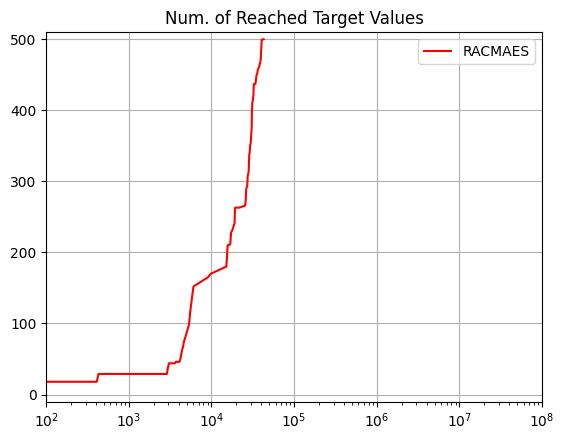

In [8]:
## plot the number of reached target values

label = opt.__class__.__name__
plt.plot(df["EvalCount"], df["reached_target_num"], color="red", label=label)
plt.xscale("log")
plt.grid()
plt.legend()

plt.ylim(-10, 510)
plt.xlim(1e2, 1e8)
plt.title("Num. of Reached Target Values")